In [ ]:
#1 Connect to Google Drive for File Access

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Step#1** This step establishes a connection between your Google Colab environment and your Google Drive, enabling seamless access to files stored in your Drive. The code uses from google.colab import drive to import the necessary module, followed by drive.mount('/content/drive'), which mounts your Drive to the Colab virtual file system at the path /content/drive. Once mounted, you can read from and write to your Drive as if it were part of the local file system. If the Drive is already mounted, Colab will notify you and suggest using force_remount=True if you need to refresh the connection.



In [ ]:
#2 Initialize Project and Prepare Survival Features

from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path('/content/drive/MyDrive/projects/metabric')
DATA_DIR = PROJECT_ROOT / 'data'
OUTPUTS_DIR = PROJECT_ROOT / 'outputs'
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

# The original 'METABRIC_preprocessed.parquet' was not found.
# Using 'METABRIC_cleaned_imputed.csv' found in MyDrive instead.
PREP_PATH = Path('/content/drive/MyDrive/METABRIC_cleaned_imputed.csv')
df = pd.read_csv(PREP_PATH)

print("Columns in the loaded DataFrame:")
print(df.columns.tolist())

time_col = 'Overall Survival (Months)'
event_col = 'Overall Survival Status'

# Map 'Overall Survival Status' to numerical (0 for Living, 1 for Dead)
df[event_col] = df[event_col].map({'Living': 0, 'Dead': 1})
# Drop rows where the event_col is NaN after mapping, as these cannot be converted to int.
df.dropna(subset=[event_col], inplace=True)
df[event_col] = df[event_col].astype(int)

# Exclude 'Patient ID' from feature_cols as it's not a numerical feature
# Also, one-hot encode categorical features for the CoxPH model
non_feature_cols = [time_col, event_col, 'Patient ID']
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in non_feature_cols]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

feature_cols = [c for c in df.columns if c not in non_feature_cols]

Columns in the loaded DataFrame:
['Patient ID', 'Age at Diagnosis', 'Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC', 'ER Status', 'Neoplasm Histologic Grade', 'HER2 status measured by SNP6', 'HER2 Status', 'Tumor Other Histologic Subtype', 'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster', 'Primary Tumor Laterality', 'Lymph nodes examined positive', 'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code', 'Overall Survival (Months)', 'Overall Survival Status', 'PR Status', 'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status', 'Sex', '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage', "Patient's Vital Status"]


**Step#2** This step initializes the project structure and loads the METABRIC dataset for preprocessing. It defines key directories (PROJECT_ROOT, DATA_DIR, OUTPUTS_DIR) and ensures the outputs folder exists. The dataset is loaded from a CSV file (METABRIC_cleaned_imputed.csv), and survival status is mapped to binary values (0 for Living, 1 for Dead), with rows lacking survival status removed. The script identifies categorical columns (excluding survival and ID fields) and applies one-hot encoding to prepare features for modeling. Finally, it constructs feature_cols by excluding time, event, and ID columns, ensuring the dataset is ready for survival analysis.

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 7.2 MB/s eta 0:00:00


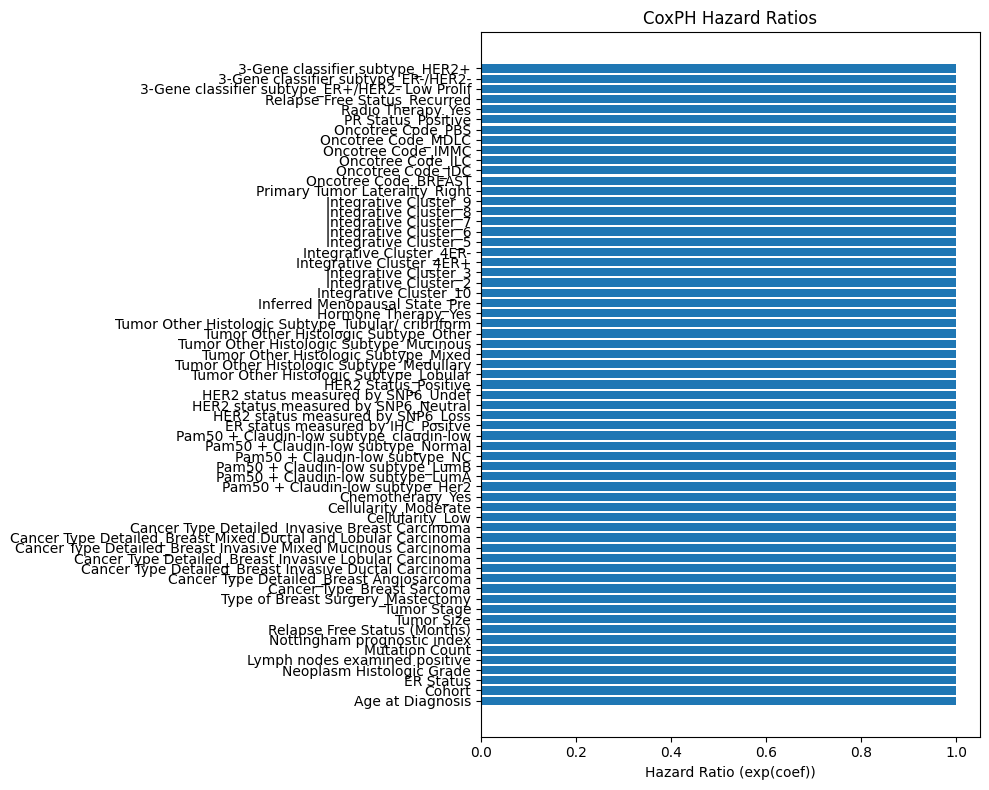

In [ ]:
#3 Train CoxPH Model and Plot Feature Impact

!pip -q install lifelines

from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.1)
cph.fit(pd.concat([df[feature_cols], df[[time_col, event_col]]], axis=1),
        duration_col=time_col, event_col=event_col)

import matplotlib.pyplot as plt

coef = cph.summary[['coef', 'exp(coef)', 'p']]
coef_sorted = coef.sort_values('exp(coef)', ascending=False)

plt.figure(figsize=(10,8))
plt.barh(coef_sorted.index, coef_sorted['exp(coef)'])
plt.xlabel('Hazard Ratio (exp(coef))')
plt.title('CoxPH Hazard Ratios')
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / '04_hazard_ratios.png', dpi=200)

**Step#3** This step fits a Cox Proportional Hazards model using the Lifelines library to analyze survival data. After installing the required package, the model is trained on the dataset using selected features along with survival time and event status, with a regularization penalty (penalizer=0.1) to stabilize estimates. The model's summary statistics—raw coefficients, exponentiated hazard ratios (exp(coef)), and p-values—are extracted and sorted by hazard ratio. A horizontal bar chart is then generated to visualize the relative impact of each feature on survival, with longer bars indicating stronger associations. The plot is saved as a high-resolution image for downstream reporting.

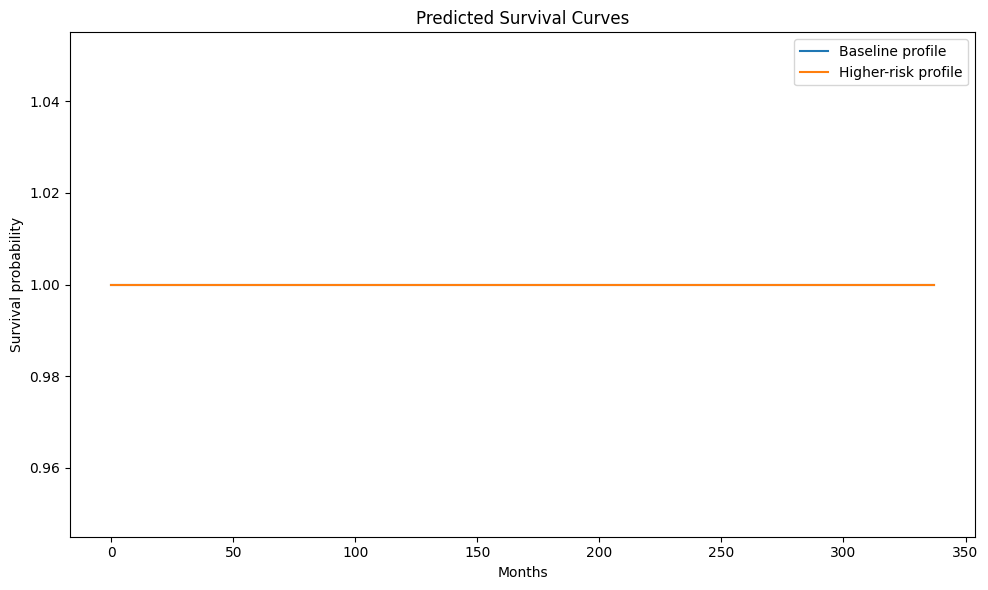

In [ ]:
#4 Compare Survival Curves for Risk Scenarios

import numpy as np

# Two example profiles: lower vs higher risk settings
baseline = df[feature_cols].median(numeric_only=True)
# For OHE columns, set to 0; adjust selected category columns as needed
baseline = baseline.fillna(0)

high_risk = baseline.copy()
# Example tweaks: increase tumor size and positive nodes
for col in baseline.index:
    if 'tumor_size_mm' in col:
        high_risk[col] = baseline[col] + 20
    if 'lymph_nodes_examined_positive' in col:
        high_risk[col] = baseline[col] + 3

timeline = np.linspace(0, df[time_col].max(), 200)
sf_baseline = cph.predict_survival_function(baseline.to_frame().T, times=timeline)
sf_high = cph.predict_survival_function(high_risk.to_frame().T, times=timeline)

plt.figure(figsize=(10,6))
plt.plot(timeline, sf_baseline.values.flatten(), label='Baseline profile')
plt.plot(timeline, sf_high.values.flatten(), label='Higher-risk profile')
plt.xlabel('Months')
plt.ylabel('Survival probability')
plt.title('Predicted Survival Curves')
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / '04_predicted_survival_curves.png', dpi=200)

**Step#4** This step generates survival curve predictions for two hypothetical patient profiles using the fitted CoxPH model. A baseline profile is constructed using the median values of all numeric features, with missing values filled as zero. A higher-risk profile is derived by increasing tumor size and the number of positive lymph nodes—two clinically relevant indicators of poor prognosis. The model then predicts survival probabilities over time for both profiles using predict_survival_function, and plots the resulting curves to visualize how risk factors affect survival. The chart, saved as a high-resolution image, illustrates the divergence in survival trajectories between lower- and higher-risk patients.

In [ ]:
#5 Summarize and Export Visualization Paths

# Collate key metrics and paths
summary = {
    'hazard_ratios_png': str(OUTPUTS_DIR / '04_hazard_ratios.png'),
    'predicted_survival_curves_png': str(OUTPUTS_DIR / '04_predicted_survival_curves.png')
}

pd.Series(summary).to_csv(OUTPUTS_DIR / '04_visualization_manifest.csv')
print('Saved visualization assets and manifest to outputs.')

Saved visualization assets and manifest to outputs.


**Step#5** This step consolidates key visualization outputs into a structured summary for downstream use. It creates a dictionary named summary containing file paths to the hazard ratios plot and the predicted survival curves image, both saved earlier in the pipeline. These paths are converted into a pandas Series and exported as a CSV file named 04_visualization_manifest.csv within the outputs directory. This manifest serves as a lightweight index of generated assets, making it easier to reference or include them in reports, presentations, or automated workflows.

Notes
Adjust paths under MyDrive to match your actual folder structure; using a single PROJECT_ROOT keeps everything reproducible.

If your categorical columns differ, update the preprocessing section accordingly so OHE produces the right features.

For reproducibility, consider saving the fitted model to Drive (e.g., via pickle) and loading it in the visualization notebook instead of refitting.